# Using neural networks for L96 parameterization

In [1]:
%matplotlib inline
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from torch import nn, optim
from torch_lr_finder import LRFinder
import torch.nn.functional as F

from sklearn.metrics import r2_score

# For reproducibility 
np.random.seed(14) 
torch.manual_seed(14);

In [2]:
from L96_model_XYtend import L96, L96_eq1_xdot, integrate_L96_2t  
    # L96_model_XYtend Adds the option to ouptput the subgrid tendencies (effect of Y on X)
from L96_model_XYtend import EulerFwd, RK2, RK4 

[Lorenz (1996)](https://www.ecmwf.int/en/elibrary/10829-predictability-problem-partly-solved) describes a "two time-scale" model in two equations (2 and 3) which are:
\begin{align}
\frac{d}{dt} X_k
&= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F - \left( \frac{hc}{b} \right) \sum_{j=0}^{J-1} Y_{j,k}
\\
\frac{d}{dt} Y_{j,k}
&= - cbY_{j+1,k} \left( Y_{j+2,k} - X_{j-1,k} \right) - c Y_{j,k} + \frac{hc}{b} X_k
\end{align}


### Create GCM classes with and without neural network parameterization

In [3]:
time_method = RK4

In [4]:
# A GCM class without any parameterization
class GCM_no_param:
    def __init__(self, F, time_stepping=time_method):
        self.F = F
        self.time_stepping = time_stepping
        
    def rhs(self, X, param):
        return L96_eq1_xdot(X, self.F)
        
    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = dt*np.arange(nt+1), np.zeros((nt+1,len(X0)))*np.nan, X0.copy()
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n+1], time[n+1] = X, dt*(n+1)
        return hist, time

In [5]:
# A GCM class including a linear parameterization in rhs of equation for tendency
class GCM:
    def __init__(self, F, parameterization, time_stepping=time_method):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping
        
    def rhs(self, X, param):
        return L96_eq1_xdot(X, self.F) - self.parameterization(param,X)
        
    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = dt*np.arange(nt+1), np.zeros((nt+1,len(X0)))*np.nan, X0.copy()
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n+1], time[n+1] = X, dt*(n+1)
        return hist, time

In [6]:
# A GCM class including a neural network parameterization in rhs of equation for tendency
class GCM_network:
    def __init__(self, F, network, time_stepping=time_method):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping
        
    def rhs(self, X, param):
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X).double()
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X, 0)).double()
        return L96_eq1_xdot(X, self.F) + np.squeeze(self.network(X_torch).data.numpy()) # Adding NN parameterization
        
    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = dt*np.arange(nt+1), np.zeros((nt+1,len(X0)))*np.nan, X0.copy()
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n+1], time[n+1] = X, dt*(n+1)
        return hist, time

In [7]:
time_steps = 20000
Forcing, dt, T = 18, 0.01, 0.01*time_steps

# Create a "real world" with K=8 and J=32
W = L96(8, 32, F=Forcing)

#### Getting training data (input output pairs): 

In [8]:
# Get training data for the neural network. 
# Run the true state and output subgrid tendencies (the effect of Y on X is xytrue):
Xtrue, _, _, xytrue = W.run(dt, T, store=True)

#### Split to train and test (validation) data:

In [9]:
val_size = 4000 # number of time steps for validation

# train:
Xtrue_train = Xtrue[:-val_size,:] #Flatten because we first use single input as a sample
subgrid_tend_train = xytrue[:-val_size,:]

# test:
Xtrue_test = Xtrue[-val_size:,:]
subgrid_tend_test = xytrue[-val_size:,:]

### Use data loaders 

- Dataset and Dataloader classes provide a very convenient way of iterating over a dataset while training your machine learning model.

- We need to iterate over the data because it is very slow and memory-intensive to hold all the data and to use gradient decent over all the data simultaneously (see more details [here](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) and [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html))

<!-- This provides a very convenient way of separating the data preparation part from the training procedure.  -->

In [10]:
# Define a data loader
BATCH_SIZE = 1024 # Number of sample in each batch

# Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.
local_torch_dataset = Data.TensorDataset(
    torch.from_numpy(np.reshape(Xtrue_train,-1)).double(),
    torch.from_numpy(np.reshape(subgrid_tend_train,-1)).double()
)
loader_local = Data.DataLoader(
        dataset=local_torch_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True)

In [11]:
# Define a test dataloader

local_torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.reshape(Xtrue_test,-1)).double(),
    torch.from_numpy(np.reshape(subgrid_tend_test,-1)).double()
)
loader_local_test = Data.DataLoader(
        dataset=local_torch_dataset_test,
        batch_size=BATCH_SIZE,
        shuffle=True)

tensor([ 1.0779, -4.4785,  0.9488,  ...,  5.0404,  2.3406,  0.6620],
       dtype=torch.float64)
tensor([-4.2664,  3.5071, -2.4230,  ..., -9.0096, -5.8614, -0.9827],
       dtype=torch.float64)


Text(0, 0.5, 'subgrid tendency')

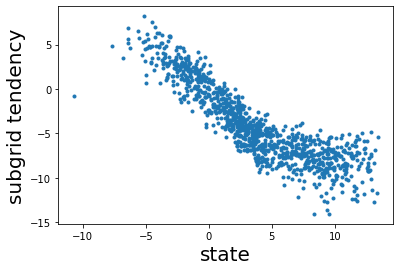

In [12]:
dataiter = iter(loader_local) # iterating over the data to get one batch
X_iter, subgrid_tend_iter = dataiter.next()

print(X_iter)
print(subgrid_tend_iter)

fontsize = 20
plt.plot(X_iter,subgrid_tend_iter,'.')
plt.xlabel('state',fontsize=fontsize)
plt.ylabel('subgrid tendency',fontsize=fontsize)

## Define network structure in pytorch 
If you want to learn more:

https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

#### Neural networks can have many different structures. 
- #### Here we will consider fully connected networks
- #### To undersand fully connected networks, we only need to understand Linear regression (and gradient descent).



<img
src="https://miro.medium.com/max/720/1*VHOUViL8dHGfvxCsswPv-Q.png" width=400>



### First, we will build a linear regression 'network' and later see how to generalize the linear regression in order to use fully connected neural network. 

In [13]:
# Define a network structure in pytorch (here it is a linear network)
class linear_reg(nn.Module):
    def __init__(self):
        super(linear_reg, self).__init__()
        self.linear1 = nn.Linear(1, 1) # a single input and a single output
    def forward(self, x): 
        # when calling the model ('linear_reg(input)') it calls automatically the forward method we defined 
        # (via __call__ - see https://github.com/pytorch/pytorch/blob/472be69a736c0b2aece4883be9f8b18e2f3dfbbd/torch/nn/modules/module.py#L487)
        x = self.linear1(x) 
        return x

In [14]:
lin_net = linear_reg().double()
print(lin_net)

linear_reg(
  (linear1): Linear(in_features=1, out_features=1, bias=True)
)


### Using the nework to get a prediction


In [15]:
# An example of how to plug a sample into the network
input1 = torch.randn(1, 1).double()
out = lin_net(input1) 
print('The output of the random input is:',out.detach().numpy())

The output of the random input is: [[-0.34709773]]


### To adjust (optimize) the weights we need to define a loss function

In [16]:
criterion = torch.nn.MSELoss() # MSE loss function
X_tmp = next(iter(loader_local))
y_tmp = lin_net(torch.unsqueeze(X_tmp[0],1)) # Predict
loss = criterion(y_tmp, torch.unsqueeze(X_tmp[1],1)) # calculate the MSE loss loss
print(loss)

tensor(82.0280, dtype=torch.float64, grad_fn=<MseLossBackward>)


### Calculating gradients

In [17]:
lin_net.zero_grad() # Zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(lin_net.linear1.bias.grad)

loss.backward(retain_graph=True) # Computes the gradient of all components current tensor

print('conv1.bias.grad after backward')
print(lin_net.linear1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([12.5411], dtype=torch.float64)


### Updating the weights using optimizer (basically built-in methods for optimization such as SGD, Adam, etc.)

In [18]:
optimizer = optim.SGD(lin_net.parameters(), lr=0.003, momentum=0.9)
print('Before backward pass: \n',list(lin_net.parameters())[0].data.numpy())
loss.backward(retain_graph=True)
optimizer.step()
print('After backward pass: \n',list(lin_net.parameters())[0].data.numpy())

Before backward pass: 
 [[0.5351125]]
After backward pass: 
 [[-0.09342995]]


it’s crucial you choose the correct learning rate ($LR$) as otherwise your network will either fail to train, or take much longer to converge. [Here](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d) you can read more about the momentum term in SGD.

### The  effective value of the gradient (V) at step t in SGD with momentum ($\beta$):
### $V_t = \beta V_{t-1} + (1-\beta) \nabla_w L(W,X,y)$

### and the updates to the weights will be:
### $w^{new} = w^{old} - LR * V_t$

## Using Adam (an adaptive learning rate optimization algorithm)

The choice of which optimizer we choose might be very important. It will determine how fast the network will be able to learn. Adam is a very popular choice (read more [here](https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c) about Adam, and [here](https://ruder.io/optimizing-gradient-descent/index.html#adam) about many types of different optimizers). 

- #### Adam is an adaptive learning rate method, which means, it computes individual learning rates for different parameters.


## Combining it all together:  training the whole network

In [19]:
def train_model(net,criterion,trainloader,optimizer):
    net.train()
    test_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x) # Inputs
        b_y = Variable(batch_y) # outputs
        if len(b_x.shape) == 1: 
            # This if block is needed to add a dummy dimension if our inputs are 1D 
            # (where each number is a different sample)
            prediction = torch.squeeze(net(torch.unsqueeze(b_x,1)))# input x and predict based on x
        else:
            prediction = net(b_x)
        loss = criterion(prediction, b_y)   # Calculating loss 
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights

In [20]:
def test_model(net,criterion,trainloader,optimizer, text = 'validation'):
    net.eval() # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
            b_x = Variable(batch_x) # Inputs
            b_y = Variable(batch_y) # outputs
            if len(b_x.shape) == 1: 
                # This if block is needed to add a dummy dimension if our inputs are 1D 
                # (where each number is a different sample)
                prediction = torch.squeeze(net(torch.unsqueeze(b_x,1)))# input x and predict based on x
            else:
                prediction = net(b_x)
            loss = criterion(prediction, b_y)   # Calculating loss 
            test_loss = test_loss + loss.data.numpy() # Keep track of the loss 
        test_loss /= len(trainloader) # dividing by the number of batches
        print(text + ' loss:',test_loss)
    return test_loss

In [21]:
n_epochs = 3 #Number of epochs (the number of times we iterate over the entire training data during training)
optimizer = optim.Adam(lin_net.parameters(), lr=0.03) # If we have time we can discuss later the Adam optimizer
for epoch in range(1, n_epochs + 1):
    train_model(lin_net, criterion, loader_local, optimizer)
    test_model (lin_net, criterion, loader_local, optimizer, 'train')
    test_model (lin_net, criterion, loader_local_test,optimizer)

train loss: 4.031398794199103
validation loss: 4.033943566623085
train loss: 3.999864900758534
validation loss: 4.029444259149283
train loss: 4.012311896769768
validation loss: 4.013189358764803


In [22]:
weights = np.array([lin_net.linear1.weight.data.numpy()[0][0], 
                    lin_net.linear1.bias.data.numpy()[0]])
print(weights)

[-0.85381206 -0.77764827]


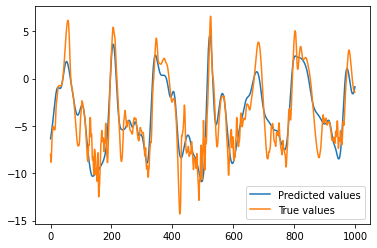

In [23]:
preds22 = lin_net(torch.unsqueeze(torch.from_numpy(np.reshape(Xtrue_test[:,1],-1)).double(),1))
plt.plot(preds22.detach().numpy()[0:1000], label='Predicted values')
plt.plot(subgrid_tend_test[:1000,1], label='True values');

plt.legend();

### Now we put the simple linear parameterization back to the GCM

In [24]:
T_test = 10

# Full L96 model
X_full, _, _, _ = W.run(dt, T_test) 

init_cond = Xtrue[-1,:]

# GCM parameterized by the linear network
gcm_net = GCM_network(Forcing, lin_net)
Xnn_1layer,t = gcm_net(init_cond ,dt, int(T_test/dt), lin_net)

# GCM parameterized without parameterization
gcm_no_param = GCM_no_param(Forcing)
X_no_param, t = gcm_no_param(init_cond ,dt, int(T_test/dt))

# GCM with naive parameterization
naive_parameterization= lambda param, X : np.polyval(param, X)
gcm = GCM(Forcing, naive_parameterization)
#X_param, t = gcm(init_cond, dt, int(T/dt), param=[0.85439536, 1.75218026])
X_param, t = gcm(init_cond, dt, int(T/dt), param=-weights)

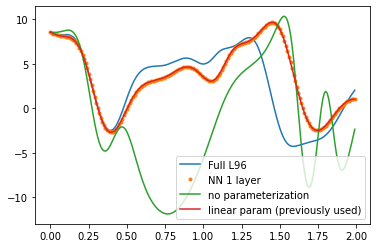

In [25]:
time_i = 200
plt.plot(t[:time_i], X_full[:time_i,4], label='Full L96');
plt.plot(t[:time_i], Xnn_1layer[:time_i,4], '.', label='NN 1 layer');
plt.plot(t[:time_i], X_no_param[:time_i,4], label='no parameterization');
plt.plot(t[:time_i], X_param[:time_i,4], label='linear param (previously used)');

plt.legend();

# Using a deeper network  for the Lorenz 96  (and using non-local features)

<img src="https://www.researchgate.net/publication/319201436/figure/fig1/AS:869115023589376@1584224577926/Visualisation-of-a-two-scale-Lorenz-96-system-with-J-8-and-K-6-Global-scale-values.png" width=400> *Fig. 1: Visualisation of a two-scale Lorenz '96 system with J = 8 and K = 6. Global-scale values ($X_k$) are updated based on neighbouring values and a reduction applied to the local-scale values ($Y_{j,k}$) associated with that value. Local-scale values are updated based on neighbouring values and the associated global-scale value. The neighbourhood topology of both the local and global-scale values is circular. Image from [Exploiting the chaotic behaviour of atmospheric models with reconfigurable architectures - Scientific Figure on ResearchGate.](https://www.researchgate.net/figure/Visualisation-of-a-two-scale-Lorenz-96-system-with-J-8-and-K-6-Global-scale-values_fig1_319201436)*



## Create non-local train/test data sets (8 inputs, 8 outputs)

In [26]:
# Create non-local training data 
BATCH_SIZE = 1024 # Number of sample in each batch

# Define a data loader (8 inputs, 8 outputs)
torch_dataset = Data.TensorDataset(
    torch.from_numpy(Xtrue_train).double(),
    torch.from_numpy(subgrid_tend_train).double()
)
loader = Data.DataLoader(
        dataset=torch_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True)

In [27]:
# Define a test dataloader (8 inputs, 8 outputs)
torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(Xtrue_test).double(),
    torch.from_numpy(subgrid_tend_test).double()
)
loader_test = Data.DataLoader(
        dataset=torch_dataset_test,
        batch_size=BATCH_SIZE,
        shuffle=True)

## Creating a class of a 3 layer fully-connected network

In [28]:
#define network structure in pytorch 
import torch.nn.functional as FF

class Net_ANN(nn.Module):
    def __init__(self):
        super(Net_ANN, self).__init__()
        self.linear1 = nn.Linear(8, 16) # 8 inputs, 16 neurons for first hidden layer
        self.linear2 = nn.Linear(16, 16) # 16 neurons for second hidden layer
        self.linear3 = nn.Linear(16, 8)  # 8 outputs

    def forward(self, x):
        x = FF.relu(self.linear1(x))
        x = FF.relu(self.linear2(x))
        x = self.linear3(x)
        return x

## Activation function - ReLU (a popular choice)

#### If layers contain only matrix multiplications, everything would be linear. 
- e.g., 2 layers of weight matrices  A and B (x is the input) would give $A(Bx)$, which is linear (in x)
- Therefore, we need to introduce some non-linearity (activation function). 

The Neural Network with 2 layers of weight matrices  A and B is actually $A(\phi(Bx))$ where $\phi$ is an actication function


The ReLu ativation function is just max(0,X) - and this what is enabling a typical NN to be a nonlinear function of the inputs!

Text(0.5, 1.0, 'ReLU')

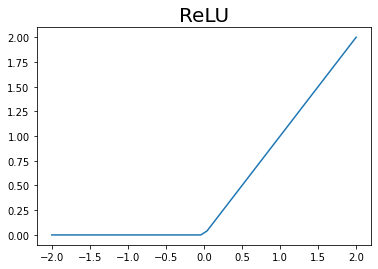

In [29]:
x = np.linspace(-2,2,50)
plt.plot(x,np.maximum(x,0))
plt.title('ReLU',fontsize = 20)

In [30]:
torch.manual_seed(14) # For reproducibility 
nn_3l = Net_ANN().double()

### Train:

train loss: 30.11180772143204
validation loss: 30.111488766495224
train loss: 19.263831677690327
validation loss: 19.337659873800604
train loss: 12.402684663953758
validation loss: 12.436179414922997
train loss: 8.81440697775228
validation loss: 8.787192252591204
train loss: 7.313901599976648
validation loss: 7.2404689526537895
train loss: 6.337104435511646
validation loss: 6.299686276962988
train loss: 5.505491900550972
validation loss: 5.526018077307695
train loss: 4.77809299777627
validation loss: 4.82060586766567
train loss: 4.234707634503158
validation loss: 4.270117158604632
train loss: 3.9046786860304814
validation loss: 3.927080182622065
train loss: 3.7006387012752904
validation loss: 3.708834223387499
train loss: 3.53828639551231
validation loss: 3.5379933438476114
train loss: 3.3695998676676227
validation loss: 3.3622930771036277
train loss: 3.2052531276920253
validation loss: 3.1760497000764576
train loss: 3.066340120378593
validation loss: 3.0434759468082313
train loss: 2.9

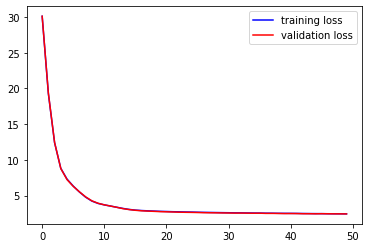

In [31]:
n_epochs = 50 #Number of epocs
optimizer = optim.Adam(nn_3l.parameters(), lr=0.003)
validation_loss = list()
train_loss = list()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l,criterion,loader,optimizer)
    train_loss.append(test_model(nn_3l,criterion,loader,optimizer, 'train'))
    validation_loss.append(test_model(nn_3l,criterion,loader_test,optimizer))
plt.plot(train_loss,'b', label='training loss');
plt.plot(validation_loss,'r', label='validation loss');

plt.legend();

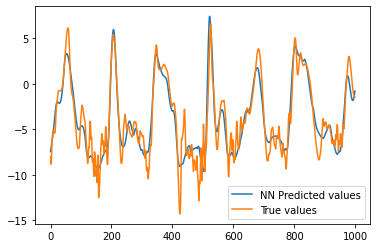

In [32]:
preds22 = nn_3l(torch.from_numpy(Xtrue_test[:,:]).double())
plt.plot(preds22.detach().numpy()[0:1000,1], label='NN Predicted values')
plt.plot(subgrid_tend_test[:1000,1], label='True values');

plt.legend();

In [33]:
T_test = 5

# GCM parameterized by the global 3-layer network
gcm_net_3layers = GCM_network(Forcing, nn_3l)
Xnn_3layer, t = gcm_net_3layers(init_cond ,dt, int(T_test/dt), nn_3l)

# GCM parameterized by the linear network
gcm_net_1layers = GCM_network(Forcing, lin_net)
Xnn_1layer, t = gcm_net_1layers(init_cond ,dt, int(T_test/dt), lin_net)

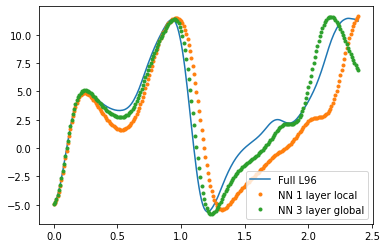

In [34]:
time_i = 240
channel = 1
plt.plot(t[:time_i], X_full[:time_i,channel], label='Full L96');
plt.plot(t[:time_i], Xnn_1layer[:time_i,channel],'.', label='NN 1 layer local');
plt.plot(t[:time_i], Xnn_3layer[:time_i,channel],'.', label='NN 3 layer global');

plt.legend();

In [35]:
# Checking over 100 different initial conditions... 
err1L = list()
err3L = list()
T_test = 1
for i in range(100):
    init_cond_temp = Xtrue[i*10,:]
    gcm_net_3layers = GCM_network(Forcing,nn_3l)
    Xnn_3layer_tmp,t = gcm_net_3layers(init_cond_temp ,dt, int(T_test/dt),nn_3l)

    gcm_net_1layers = GCM_network(Forcing,lin_net)
    Xnn_1layer_tmp ,t = gcm_net_1layers(init_cond_temp ,dt, int(T_test/dt),lin_net)
    
    err1L.append(np.sum(np.abs(Xtrue[i*10:i*10 + T_test*100+1] - Xnn_1layer_tmp)))
    err3L.append(np.sum(np.abs(Xtrue[i*10:i*10 + T_test*100+1] - Xnn_3layer_tmp)))
print("Sum of errors for 1 layer local:", sum(err1L))
print("Sum of errors for 3 layer global:", sum(err3L))

Sum of errors for 1 layer local: 54879.71262027023
Sum of errors for 3 layer global: 36620.43431306215


### Training some more to further improve performance

train loss: 2.434635927663836
validation loss: 2.429168566846407
train loss: 2.428913632896838
validation loss: 2.4300337726487817
train loss: 2.4239444380850697
validation loss: 2.4198508993301484
train loss: 2.4205368192294374
validation loss: 2.4069750705478796
train loss: 2.412055271575923
validation loss: 2.400072088371188
train loss: 2.404905537073067
validation loss: 2.3933276020558325
train loss: 2.4088475186527014
validation loss: 2.3852281616748576
train loss: 2.3996792042532515
validation loss: 2.39696864498644
train loss: 2.4021544819403964
validation loss: 2.4014853221735857
train loss: 2.3984929249850153
validation loss: 2.395244239735291
train loss: 2.3855097488919155
validation loss: 2.3724779786032797
train loss: 2.380208356145168
validation loss: 2.365414996535522
train loss: 2.3750388846930566
validation loss: 2.3712857795113322
train loss: 2.374857144141766
validation loss: 2.3589953786451914
train loss: 2.3660203347648747
validation loss: 2.371097055113945
train lo

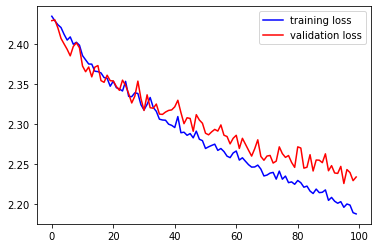

In [36]:
n_epochs = 100 # Number of epochs
validation_loss = list()
train_loss = list()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l,criterion, loader, optimizer, 'train'))
    validation_loss.append(test_model(nn_3l, criterion, loader_test, optimizer))
plt.plot(train_loss, 'b', label='training loss');
plt.plot(validation_loss, 'r', label='validation loss');

plt.legend();

In [37]:
# Save network
#PATH = '/Users/yani/Dropbox/MIT/m2lines/L96_demo/networks/network_3_layers_100_epoches.pth'
PATH = './networks/network_3_layers_100_epoches.pth'
torch.save(nn_3l.state_dict(), PATH)

# Load network
# path_load = '/Users/yani/Dropbox/MIT/m2lines/L96_demo/networks/network_3_layers_100_epoches.pth'
# nn_3l.load_state_dict(torch.load(path_load))

# Regularization and overfitting

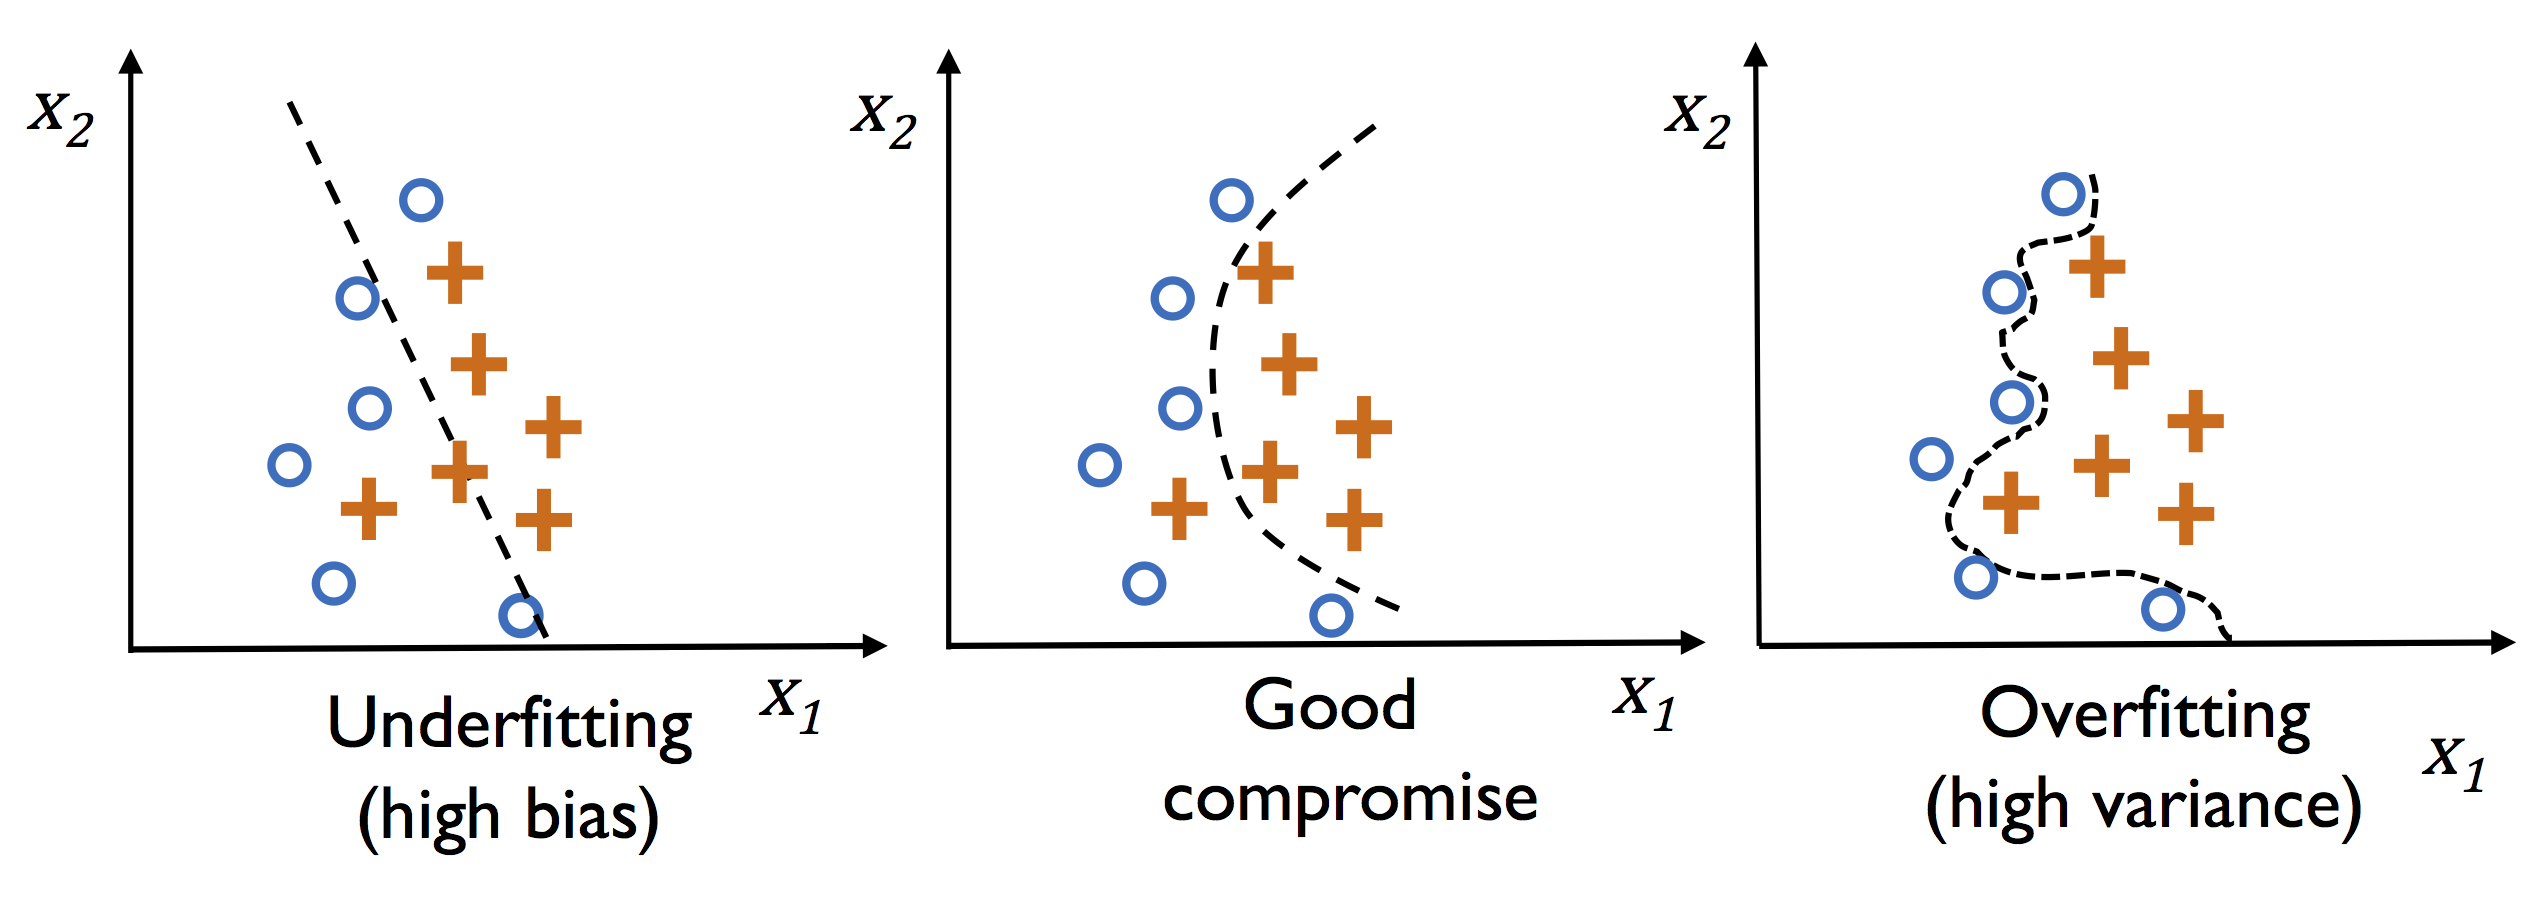

In [38]:
from IPython.display import Image
Image(filename='figs/overfitting.png', width=700)
# The figure below is taken from Python Machine Learning book by Sebastian Raschka

### Regularization methods are aimed to tackle overfitting. 

For example, the model on the far right of the plot predicts perfectly on the given set, yet it's not the best choice. Why is that? If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

All ML algorithms has some form of regularization. 

### Useful ways to think of regularization:
- #### Putting constraints on the model
Aiming to have a better generalizability (avoid modeling the noise or "remembering" training data). 
- #### Adding a term to the loss function so that: Loss = Training Loss + Regularization
Put a penalty for making the model more complex. 

Very braodly speaking (just to gain intuition) - if we want to reduce the training loss (reduce bias) we should try using a more complex model (if we have enough data) and if we want to reduce overfitting (reduce variace) we should simplify or constraint the model we use (increase regularization). 

# Regularization of Neural Networks

- Dropout (added in the definition of the network). 
- Early stopping
- Weight decay (added in the optimizer part - see optim.Adam)
- Data augmentation (usually for images)

### Weight decay (L2 norm)

weight decay is usually defined as a term that’s added directly to the update rule.
Namely, to update a certain weight $w$ in the $i+1$ iteration, we would use a modified rule:

$w_{i+1} = w_{i} - \gamma ( \frac{\partial L}{\partial w} + A w_{i})$

In practice, this is almost identical to L_2 regularization, though there is some difference (e.g., see [here](https://bbabenko.github.io/weight-decay/))

Weight decay is one of the parameters of the optimizer - try torch.optim.SGD

#### Add a weight decay to a network and train it again

train loss: 25.0825015169306
validation loss: 25.049032277718407
train loss: 16.673728851158803
validation loss: 16.77192555237221
train loss: 13.00830806010512
validation loss: 13.081946475951678
train loss: 9.91722788194368
validation loss: 10.118957867625786
train loss: 7.175378945000125
validation loss: 7.293626676235027
train loss: 6.072874196493369
validation loss: 6.183393314036107
train loss: 5.21722678833297
validation loss: 5.350363496483547
train loss: 4.503046703794335
validation loss: 4.611535134246086
train loss: 3.9960280411728184
validation loss: 4.07528302675404
train loss: 3.7228383732766464
validation loss: 3.810653057880291


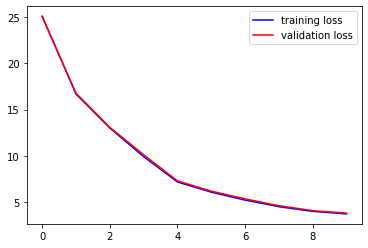

In [39]:
n_epochs = 10 # Number of epochs
nn_3l_decay = Net_ANN().double()
optimizer = optim.Adam(nn_3l_decay.parameters(), lr=0.003, weight_decay=0.1)
validation_loss = list()
train_loss = list()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_decay, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l_decay, criterion, loader, optimizer, 'train'))
    validation_loss.append(test_model(nn_3l_decay, criterion, loader_test, optimizer))
plt.plot(train_loss, 'b', label='training loss');
plt.plot(validation_loss, 'r', label='validation loss');

plt.legend();

### Dropout

By dropping a unit out, we mean temporarily removing it from the network while training, along with all its incoming and outgoing connections. 
See more details [here](http://jmlr.org/papers/v15/srivastava14a.html).
It is usually the most useful regularization that we can do in fully connected layers

In convolutional layers dropout makes less sense - see more discussion [here](https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html)


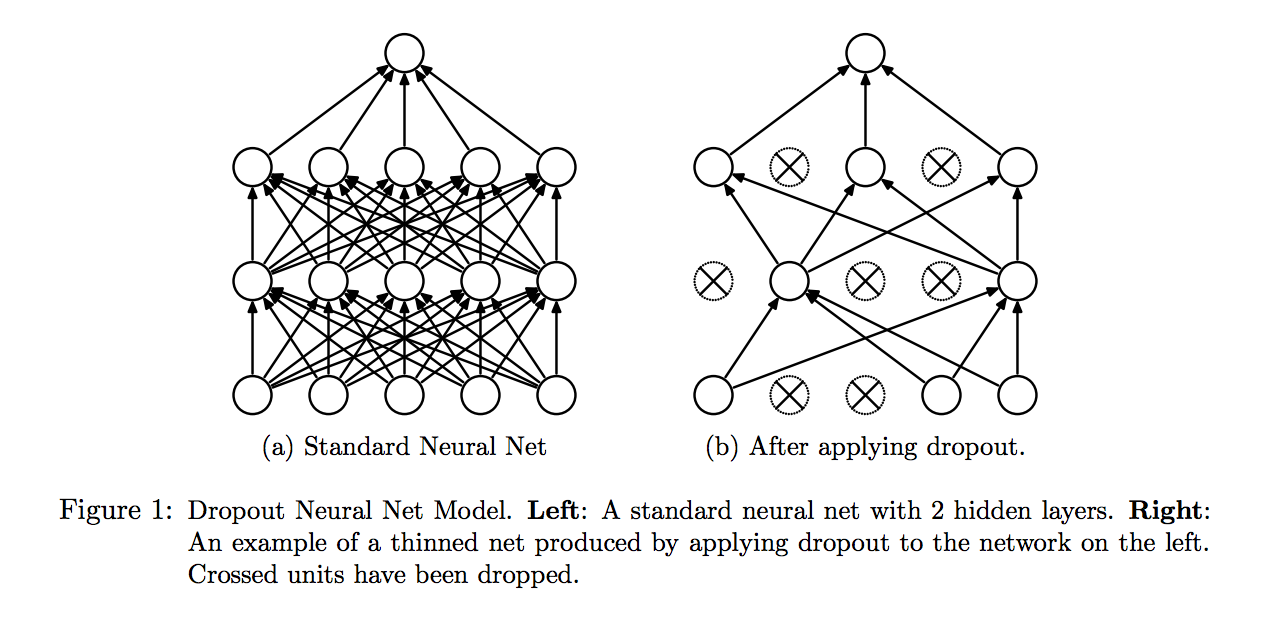

In [40]:
# Image taken from: http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
Image(filename='figs/Dropout_layer.png', width=700)

In [41]:
# Define fully connected NN with dropout
class Net_ANN_dropout(nn.Module):
    def __init__(self,dropout= 0.2):
        super(Net_ANN_dropout, self).__init__()
        self.linear1 = nn.Linear(8, 16)
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 8)
        self.drop = nn.Dropout(dropout) #regularization method to prevent overfitting. 

    def forward(self, x):
        x = FF.relu(self.linear1(x))
        x = self.drop(x)
        x = FF.relu(self.linear2(x))
        x = self.drop(x)
        x = self.linear3(x)
        return x

train loss: 28.484808240649453
validation loss: 28.36343191700641
train loss: 24.058934193360237
validation loss: 24.090537031757716
train loss: 21.27406063114037
validation loss: 21.27198195883802
train loss: 19.392044580042107
validation loss: 19.39188300294986
train loss: 17.396633681889785
validation loss: 17.344299443605145
train loss: 16.740370509470736
validation loss: 16.70720303571644
train loss: 16.23467939977836
validation loss: 16.191704506276167
train loss: 16.250037406597148
validation loss: 16.221783361408214
train loss: 15.773463011807655
validation loss: 15.717891507632938
train loss: 15.669752788975796
validation loss: 15.638615253595578


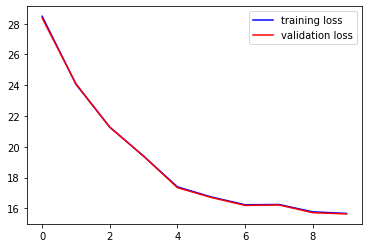

In [42]:
nn_3l_drop = Net_ANN_dropout(dropout = 0.8).double() # Exagerated dropout... 
n_epochs = 10 # Number of epocs
optimizer = optim.Adam(nn_3l_drop.parameters(), lr=0.01)
validation_loss = list()
train_loss = list()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_drop,criterion,loader,optimizer)
    train_loss.append(test_model(nn_3l_drop,criterion,loader,optimizer, 'train'))
    validation_loss.append(test_model(nn_3l_drop,criterion,loader_test,optimizer))
plt.plot(train_loss,'b', label='training loss');
plt.plot(validation_loss,'r', label='validation loss');

plt.legend();

# How to choose a learning rate?

### Visuzlization of the loss function

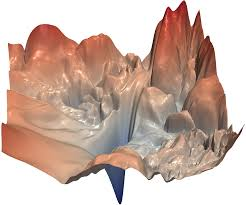

In [43]:
# Image taken from: https://papers.nips.cc/paper/7875-visualizing-the-loss-landscape-of-neural-nets.pdf
Image(filename='figs/Loss_function_vis_NN.jpeg', width=400)

## Finding an optimal learning rate

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.41E-02


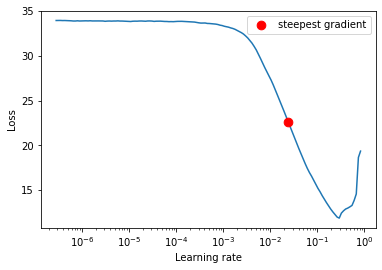

In [44]:
nn_3l_LR = Net_ANN().double()
optimizer = optim.Adam(nn_3l_LR.parameters(), lr=1e-7)
lr_finder = LRFinder(nn_3l_LR, optimizer, criterion)
lr_finder.range_test(loader, end_lr=100, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

train loss: 15.742650062721374
validation loss: 15.845016329352404
train loss: 8.862789414310365
validation loss: 8.86731106841563
train loss: 5.9976255795332705
validation loss: 5.93323644768446
train loss: 4.339397239578945
validation loss: 4.320742143066615
train loss: 3.455794476586731
validation loss: 3.4157997378306773
train loss: 3.015226337630515
validation loss: 2.9902947603794496
train loss: 2.864350390595094
validation loss: 2.8642880411533995
train loss: 2.7744323605230554
validation loss: 2.8072393809133005
train loss: 2.727702354869855
validation loss: 2.76075460208739
train loss: 2.7001605404092692
validation loss: 2.7501063922466886
train loss: 2.6504403311393085
validation loss: 2.697737539916223
train loss: 2.634050028353713
validation loss: 2.6842141985851753
train loss: 2.615288440410766
validation loss: 2.694124169050167
train loss: 2.5826183578756337
validation loss: 2.657675169962701
train loss: 2.5625074060694435
validation loss: 2.6145567082536374
train loss: 2

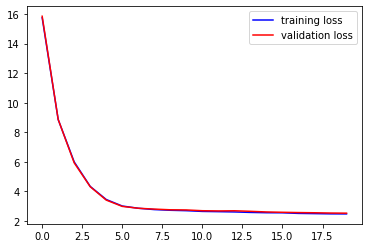

In [45]:
n_epochs = 20 # Number of epocs
optimizer = optim.Adam(nn_3l_LR.parameters(), lr=0.01)
validation_loss = list()
train_loss = list()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_LR,criterion,loader,optimizer)
    train_loss.append(test_model(nn_3l_LR,criterion,loader,optimizer, 'train'))
    validation_loss.append(test_model(nn_3l_LR,criterion,loader_test,optimizer))
plt.plot(train_loss,'b', label='training loss');
plt.plot(validation_loss,'r', label='validation loss');

plt.legend();

### We converged much faster than before. 

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.30E-07


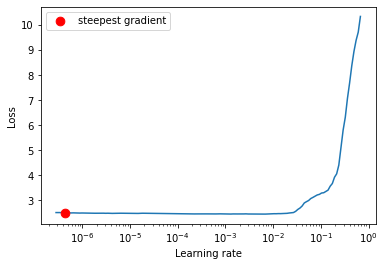

In [46]:
optimizer = optim.Adam(nn_3l_LR.parameters(), lr=1e-7)
lr_finder = LRFinder(nn_3l_LR, optimizer, criterion)
lr_finder.range_test(loader, end_lr=100, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

train loss: 2.456307455546646
validation loss: 2.5045980803834014
train loss: 2.4517673063470755
validation loss: 2.501554944927002
train loss: 2.4467673417893487
validation loss: 2.4920086327603634
train loss: 2.44456335640914
validation loss: 2.486884356199889
train loss: 2.4425237137021134
validation loss: 2.4844184838217687
train loss: 2.4366340701923703
validation loss: 2.4809314577281114
train loss: 2.437160824479414
validation loss: 2.4815155927499735
train loss: 2.434626617286569
validation loss: 2.4747784252998706
train loss: 2.4306482793783606
validation loss: 2.469440142626058
train loss: 2.431318215591652
validation loss: 2.4648573222297534


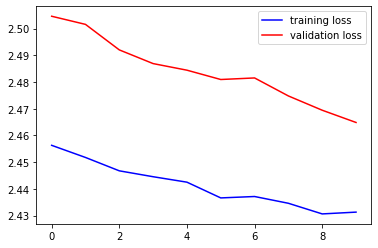

In [47]:
n_epochs = 10 #Number of epocs
optimizer = optim.Adam(nn_3l_LR.parameters(), lr=0.001)
validation_loss = list()
train_loss = list()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_LR,criterion,loader,optimizer)
    train_loss.append(test_model(nn_3l_LR,criterion,loader,optimizer, 'train'))
    validation_loss.append(test_model(nn_3l_LR,criterion,loader_test,optimizer))
plt.plot(train_loss,'b', label='training loss');
plt.plot(validation_loss,'r', label='validation loss');

plt.legend();

## I won't talk about but I recommend reading:

## BatchNormalization 

Normalize the activation values such that the hidden representation doesn’t vary drastically and also helps us to get improvement in the training speed.

## Cyclic learning rate

### To understand cyclic learning rates and the One cycle policy - read more [here](https://sgugger.github.io/the-1cycle-policy.html)

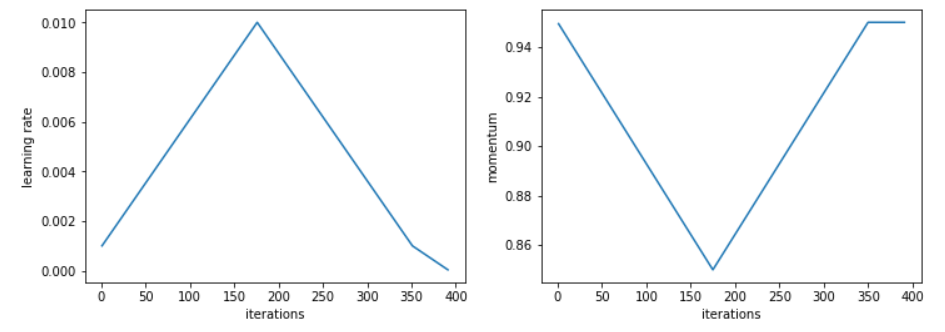

In [48]:
# Image taken from - https://docs.fast.ai/callbacks.one_cycle.html
Image(filename='figs/onecycle_params.png', width=700)

To use cyclic learning rates: optim.lr_scheduler.CyclicLR